# Gaussian Mixture Modeling in PySpark's MLlib 

GMM is a "soft" clustering method that provides a probability of how associated a data point is with a cluster as opposed to simply which cluster the data point is associated with. It works especially well for data that has multiple distributions, but can be used for any kind of data.

If you would like to learn even more about GMM I recommend the following article: https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

**Link to GMM in PySpark Documentation:**<br>
https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.clustering.GaussianMixture

In [2]:
# First let's create our PySpark instance
# import findspark
# findspark.init()

import pyspark  # only run after findspark.init()
from pyspark.sql import SparkSession

# May take awhile locally
spark = SparkSession.builder.appName("Gix").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

You are working with 1 core(s)


## About this data

Sample Sales Data, Order Info, Sales, Customer, Shipping, etc., Used for Segmentation, Customer Analytics, Clustering and More. Inspired for retail analytics. This was originally used for Pentaho DI Kettle, But I found the set could be useful for Sales Simulation training.

Originally Written by María Carina Roldán, Pentaho Community Member, BI consultant (Assert Solutions), Argentina. This work is licensed under the Creative Commons Attribution-Noncommercial-Share Alike 3.0 Unported License. Modified by Gus Segura June 2014.

**Source:** https://www.kaggle.com/kyanyoga/sample-sales-data

In [3]:
path = "Datasets/"
df = spark.read.csv(path + "sales_data_sample.csv", inferSchema=True, header=True)

In [4]:
df.limit(5).toPandas()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,None,NYC,NY,10022,USA,NA,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,None,Reims,None,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,None,Paris,None,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,None,Pasadena,CA,90003,USA,NA,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,None,San Francisco,CA,None,USA,NA,Brown,Julie,Medium


In [5]:
df.printSchema()

root
 |-- ORDERNUMBER: integer (nullable = true)
 |-- QUANTITYORDERED: integer (nullable = true)
 |-- PRICEEACH: double (nullable = true)
 |-- ORDERLINENUMBER: integer (nullable = true)
 |-- SALES: double (nullable = true)
 |-- ORDERDATE: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- QTR_ID: integer (nullable = true)
 |-- MONTH_ID: integer (nullable = true)
 |-- YEAR_ID: integer (nullable = true)
 |-- PRODUCTLINE: string (nullable = true)
 |-- MSRP: integer (nullable = true)
 |-- PRODUCTCODE: string (nullable = true)
 |-- CUSTOMERNAME: string (nullable = true)
 |-- PHONE: string (nullable = true)
 |-- ADDRESSLINE1: string (nullable = true)
 |-- ADDRESSLINE2: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- POSTALCODE: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- TERRITORY: string (nullable = true)
 |-- CONTACTLASTNAME: string (nullable = true)
 |-- CONTACTFIRSTNAME: string (nullable = tr

## Import some libraries we will need

You will notice that some of these are pythonic which means they won't distribute accross our dataframe, but we will only use them on situations were distribution is not usually necessary. I always try to use PySpark functions where ever I can, but sometimes the functionality I need is not available. In these cases I lean back on my trusty Python libraries :)

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyspark.sql.functions import col, avg
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import GaussianMixture
import numpy as np

In [9]:
# Fill in null values with average
# Since this function passes in a df, we don't need to (and cannot) create a UDF for it
# It will distribute accross our dataframe because the functions within the function are from PySpark
def fill_with_mean(df, include=set()):
    stats = df.agg(*(avg(c).alias(c) for c in df.columns if c in include))
    #     stats = stats.select(*(col(c).cast("int").alias(c) for c in stats.columns)) #IntegerType()
    return df.na.fill(stats.first().asDict())


cols_list = ["QUANTITYORDERED", "PRICEEACH", "SALES"]
df = df.select(cols_list)
columns = df.columns
df = fill_with_mean(df, columns)
df.limit(5).toPandas()

,QUANTITYORDERED,PRICEEACH,SALES
0,30,95.70,2871.00
1,34,81.35,2765.90
2,41,94.74,3884.34
3,45,83.26,3746.70
4,49,100.00,5205.27


Convert all input columns into a vector as usual

In [18]:
input_columns = df.columns  # Collect the column names as a list
vecAssembler = VectorAssembler(inputCols=input_columns, outputCol="features")
final_df = vecAssembler.transform(df)
final_df.show()

+---------------+---------+-------+--------------------+
|QUANTITYORDERED|PRICEEACH|  SALES|            features|
+---------------+---------+-------+--------------------+
|             30|     95.7| 2871.0|  [30.0,95.7,2871.0]|
|             34|    81.35| 2765.9| [34.0,81.35,2765.9]|
|             41|    94.74|3884.34|[41.0,94.74,3884.34]|
|             45|    83.26| 3746.7| [45.0,83.26,3746.7]|
|             49|    100.0|5205.27|[49.0,100.0,5205.27]|
|             36|    96.66|3479.76|[36.0,96.66,3479.76]|
|             29|    86.13|2497.77|[29.0,86.13,2497.77]|
|             48|    100.0|5512.32|[48.0,100.0,5512.32]|
|             22|    98.57|2168.54|[22.0,98.57,2168.54]|
|             41|    100.0|4708.44|[41.0,100.0,4708.44]|
|             37|    100.0|3965.66|[37.0,100.0,3965.66]|
|             23|    100.0|2333.12|[23.0,100.0,2333.12]|
|             28|    100.0|3188.64|[28.0,100.0,3188.64]|
|             34|    100.0|3676.76|[34.0,100.0,3676.76]|
|             45|    92.83|4177

## Determine optimal K

In [19]:
kmax = 50
ll = np.zeros(kmax)
for k in range(2, kmax):
    gm = GaussianMixture(k=k, tol=0.0001, maxIter=10, seed=10)
    model = gm.fit(final_df)
    summary = model.summary
    ll[k] = summary.logLikelihood

Text(0, 0.5, 'll')

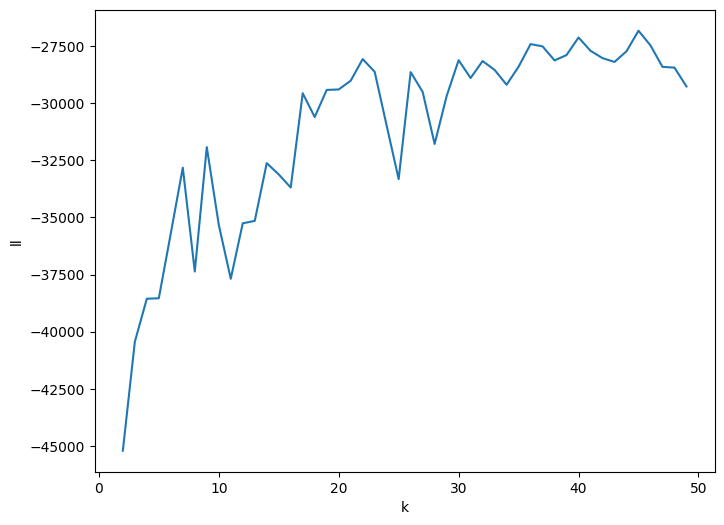

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(range(2, kmax), ll[2:kmax])
ax.set_xlabel("k")
ax.set_ylabel("ll")

In [21]:
# for the sake of speed and simplicity we will stick with k = 5
gm = GaussianMixture(k=5, maxIter=10, seed=10)
model = gm.fit(final_df)

summary = model.summary
print("Clusters: ", summary.k)
print("Cluster Sizes: ", summary.clusterSizes)
print("Log Likelihood: ", summary.logLikelihood)

weights = model.weights
print("Model Weights: :", len(weights))

print("Means: ", model.gaussiansDF.select("mean").head())

print("Cov: ", model.gaussiansDF.select("cov").head())

transformed = model.transform(final_df)  # .select("features", "prediction")

Clusters:  5
Cluster Sizes:  [21, 500, 1321, 606, 375]
Log Likelihood:  -38536.03520287095
Model Weights: : 5
Means:  Row(mean=DenseVector([57.1921, 94.5371, 8600.5984]))
Cov:  Row(cov=DenseMatrix(3, 3, [368.922, -23.1032, 17376.6617, -23.1032, 75.6298, 19941.3381, 17376.6617, 19941.3381, 11924651.5438], False))


## Reflection

Look at the 5 clusters that our model identified range in size quite a bit. There is one cluster that only has 7 cases in it as opposed to 1,307 in the largest cluster. If we were using this dataset to target customers, we may want to focus our efforts on the largest group first as we would have more bange for our buck. 

In [22]:
transformed.limit(7).toPandas()

,QUANTITYORDERED,PRICEEACH,SALES,features,probability,prediction
0,30,95.70,2871.00,"[30.0, 95.7, 2871.0]","[0.00012319578267814814, 3.165096578077064e-10...",3
1,34,81.35,2765.90,"[34.0, 81.35, 2765.9]","[0.00010533648381889139, 0.0003406214189990852...",3
2,41,94.74,3884.34,"[41.0, 94.74, 3884.34]","[0.0001387056507756689, 2.406405253782782e-05,...",4
3,45,83.26,3746.70,"[45.0, 83.26, 3746.7]","[7.52931151353599e-05, 4.5788906790414644e-05,...",4
4,49,100.00,5205.27,"[49.0, 100.0, 5205.27]","[0.00021276862280714313, 2.833230760746279e-10...",2
5,36,96.66,3479.76,"[36.0, 96.66, 3479.76]","[0.0053272425312154694, 0.00013024432790413452...",4
6,29,86.13,2497.77,"[29.0, 86.13, 2497.77]","[6.515802527983164e-05, 7.484417939349283e-10,...",3


Let's see if we can try to learn something about our clusters!

In [23]:
transformed.show(1, False)

+---------------+---------+------+------------------+----------------------------------------------------------------------------------------------------------+----------+
|QUANTITYORDERED|PRICEEACH|SALES |features          |probability                                                                                               |prediction|
+---------------+---------+------+------------------+----------------------------------------------------------------------------------------------------------+----------+
|30             |95.7     |2871.0|[30.0,95.7,2871.0]|[1.2319578267814814E-4,3.165096578077064E-10,3.139419657318812E-10,0.9998708129044579,5.99068241217983E-6]|3         |
+---------------+---------+------+------------------+----------------------------------------------------------------------------------------------------------+----------+
only showing top 1 row



In [28]:
transformed.groupBy("prediction").agg(
    {
        "prediction": "count",
        "QUANTITYORDERED": "min",
        "PRICEEACH": "min",
        "SALES": "min",
    }
).orderBy("prediction").show()

+----------+--------------+--------------------+-----------------+----------+
|prediction|min(PRICEEACH)|min(QUANTITYORDERED)|count(prediction)|min(SALES)|
+----------+--------------+--------------------+-----------------+----------+
|         0|         66.99|                   6|               21|    541.14|
|         1|         26.88|                  11|              500|    482.13|
|         2|         98.18|                   6|             1321|    785.64|
|         3|         51.15|                  10|              606|     881.4|
|         4|          60.9|                  35|              375|   2783.25|
+----------+--------------+--------------------+-----------------+----------+



In [29]:
transformed.groupBy("prediction").agg(
    {
        "prediction": "count",
        "QUANTITYORDERED": "max",
        "PRICEEACH": "max",
        "SALES": "max",
    }
).orderBy("prediction").show()

+----------+--------------+--------------------+-----------------+----------+
|prediction|max(PRICEEACH)|max(QUANTITYORDERED)|count(prediction)|max(SALES)|
+----------+--------------+--------------------+-----------------+----------+
|         0|         100.0|                  97|               21|   14082.8|
|         1|          71.0|                  64|              500|    3880.2|
|         2|         100.0|                  70|             1321|   10758.0|
|         3|         99.04|                  39|              606|   3431.75|
|         4|         99.55|                  59|              375|    5168.4|
+----------+--------------+--------------------+-----------------+----------+



In [30]:
transformed.groupBy("prediction").agg(
    {
        "prediction": "count",
        "QUANTITYORDERED": "mean",
        "PRICEEACH": "mean",
        "SALES": "mean",
    }
).orderBy("prediction").show()

+----------+------------------+--------------------+-----------------+------------------+
|prediction|    avg(PRICEEACH)|avg(QUANTITYORDERED)|count(prediction)|        avg(SALES)|
+----------+------------------+--------------------+-----------------+------------------+
|         0| 93.64809523809524|  59.904761904761905|               21| 8883.508095238098|
|         1|49.456159999999954|              37.188|              500|1862.3539200000007|
|         2| 99.98517032551098|  35.012869038607114|             1321| 4766.839182437543|
|         3|  76.8291914191419|   27.32838283828383|              606|  2101.78193069307|
|         4| 82.22527999999998|   43.73866666666667|              375| 3584.596826666667|
+----------+------------------+--------------------+-----------------+------------------+



In [31]:
limited = transformed.filter("prediction == 0")
aggregates = limited.summary("min", "mean", "max")
print("Total Cases in this Cluster: ", limited.count())
aggregates.toPandas()

Total Cases in this Cluster:  21


,summary,QUANTITYORDERED,PRICEEACH,SALES,prediction
0,min,6,66.99,541.14,0
1,mean,59.904761904761905,93.64809523809524,8883.508095238098,0.0
2,max,97,100.0,14082.8,0


# Conclusions

Of the 5 clusters, the first one seems to buy for quality (highest price per item and max sales), while the last cluster seems to be the "buy in bulk" shoppers. Cluster 3 seems to be more of a bargain hunter (lowest price each and avg sales)